<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 46


Apply ```HMM_Model_9.json``` in regions: 

Chromosome 6

* [R1 ```region_0_REGION_1_CHR_6_MEAN_CUTOFF.txt``` 1000000-20000000](#r1)
* [R2 ```region_0_REGION_2_CHR_6_MEAN_CUTOFF.txt``` 20000000-40000000](#r2) 
* [R3 ```region_0_REGION_3_CHR_6_MEAN_CUTOFF.txt``` 40000000-58000000](#r3)
* [R4 ```region_0_REGION_5_CHR_6_MEAN_CUTOFF.txt``` 63000000-80000000](#r4)
* [R5 ```region_0_REGION_5_CHR_6_MEAN_CUTOFF.txt``` 800000000-100000000](#r5)
* [R6 ```region_0_REGION_6_CHR_6_MEAN_CUTOFF.txt``` 100000000-120000000](#r6)
* [R7 ```region_0_REGION_7_CHR_6_MEAN_CUTOFF.txt``` 120000000-140000000](#r7)
* [R8 ```region_0_REGION_8_CHR_6_MEAN_CUTOFF.txt``` 140000000-160000000](#r8)
* [R9 ```region_0_REGION_9_CHR_6_MEAN_CUTOFF.txt``` 1-1000000](#r9)
* [R10 ```region_0_REGION_10_CHR_6_MEAN_CUTOFF.txt``` 160000000-170000000](#r10)


In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from helpers import read_configuration_file, INFO, WARNING
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [4]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [5]:
sns.set(color_codes=True)

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


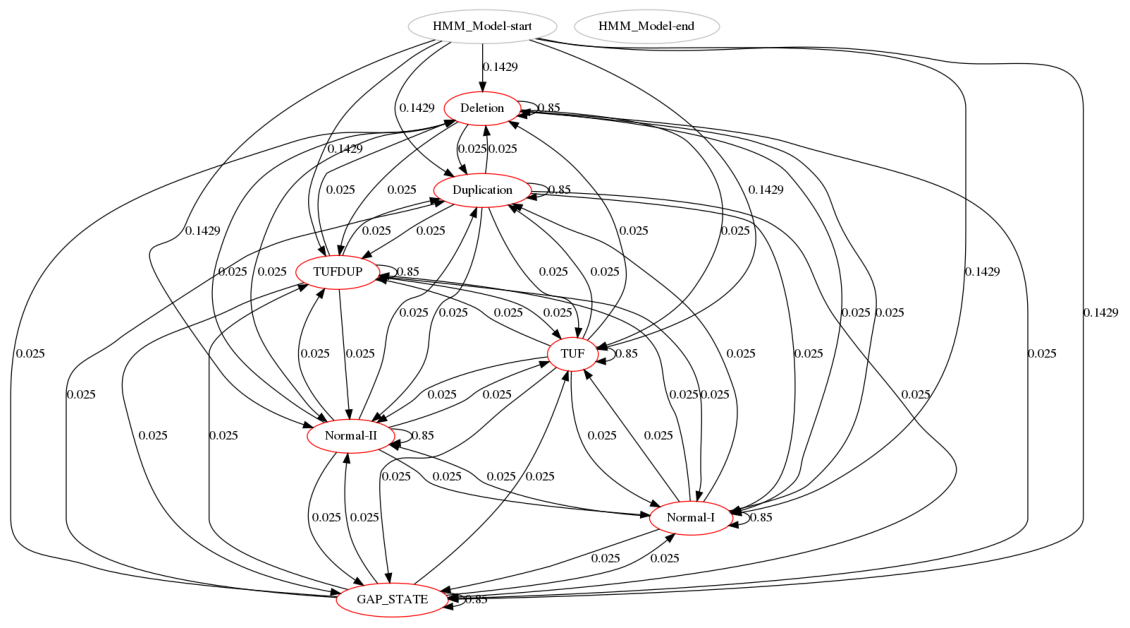

In [6]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

## <a name="r1"></a>  Region 1

In [8]:
chr='chr6'
viterbi_paths = 'viterbi_paths_chr6/'

In [7]:
# load the region we want to use for prediction
region_name = "region_0_REGION_1_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_CHR_6_MEAN_CUTOFF.txt
Sequence length:  190000


In [8]:
filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model,
                                                                         chr='chr6',
                                                                         filename=filename)

Observation length:  190000
Done. Execution time 0.6450759500003187 secs
Log-probability of ML Viterbi path:  -1280774.9047804996
Viterbi path length:  190001
There should be 0 gaps


In [9]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr6', filename=filename)

Length of path  190000
Length of TUF+DELETION+TUF state:  299


In [10]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  190000
Encountered gaps:  0


In [11]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 46, 'Normal-I': 135430, 'Normal-II': 53414, 'Deletion': 138, 'Single-Deletion': 0, 'TUF': 972, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


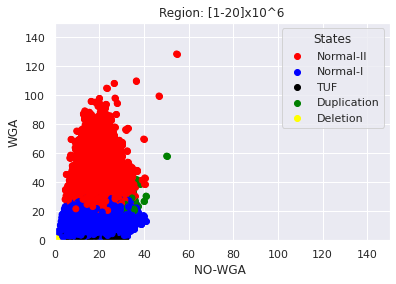

HMM labels color:  {'red': [2, 53414], 'blue': [1, 135430], 'black': [5, 972], 'green': [0, 46], 'yellow': [3, 138]}


In [12]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [1-20]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [13]:
for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  26.403695652173916 43.219688516068054
NO-WGA mean/var:  33.945 14.646668478260873
State:  Normal-I
WGA mean/var:  16.36099438824485 24.974014286241854
NO-WGA mean/var:  18.117137414162297 20.614418662281043
State:  Normal-II
WGA mean/var:  32.22956078930618 76.84668226113223
NO-WGA mean/var:  19.130764031901748 18.69464525255285
State:  Deletion
WGA mean/var:  1.466159420289855 1.7278990180634322
NO-WGA mean/var:  1.9513043478260867 2.0635794580970384
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.602510288065844 2.4962646861081477
NO-WGA mean/var:  15.057839506172838 30.193022081237622
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


## <a name="r2"></a> Region 2

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_2_CHR_6_MEAN_CUTOFF.txt
Sequence length:  199989
Observation length:  199989
Done. Execution time 0.709727475001273 secs
Log-probability of ML Viterbi path:  -1363884.4425836208
Viterbi path length:  199990
There should be 0 gaps
Length of path  199989
Length of TUF+DELETION+TUF state:  370
Length of WGA Observations:  199989
Encountered gaps:  0
{'Duplication': 247, 'Normal-I': 137608, 'Normal-II': 60125, 'Deletion': 748, 'Single-Deletion': 0, 'TUF': 1261, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


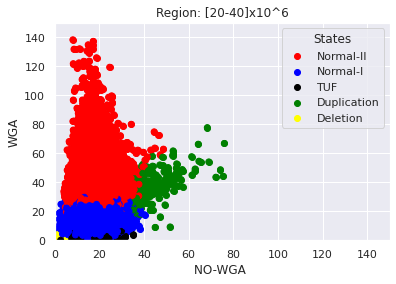

HMM labels color:  {'red': [2, 60125], 'blue': [1, 137608], 'black': [5, 1261], 'green': [0, 247], 'yellow': [3, 748]}
State:  Duplication
WGA mean/var:  33.444210526315786 124.30156121883658
NO-WGA mean/var:  40.70481781376518 94.80023063482437
State:  Normal-I
WGA mean/var:  16.42349848845997 25.07891615282313
NO-WGA mean/var:  17.768161662112664 22.008138426949483
State:  Normal-II
WGA mean/var:  32.9971679002079 95.86742204324403
NO-WGA mean/var:  18.491930145530148 20.49571057474613
State:  Deletion
WGA mean/var:  0.826711229946524 1.4935335690182732
NO-WGA mean/var:  0.8833823529411764 1.5830451104907204
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.7832513877874705 2.2386373269707147
NO-WGA mean/var:  14.64411578112609 31.384981870813608
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [14]:
# load the region we want to use for prediction
region_name = "region_0_REGION_2_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr6',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr6', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [20-40]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r3"></a>  Region 3

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_3_CHR_6_MEAN_CUTOFF.txt
Sequence length:  179995
Observation length:  179995
Done. Execution time 0.6005623380006 secs
Log-probability of ML Viterbi path:  -1232702.5882845346
Viterbi path length:  179996
There should be 0 gaps
Length of path  179995
Length of TUF+DELETION+TUF state:  0
TUF_DELETE_TUF is empty
Length of WGA Observations:  179995
Encountered gaps:  0
{'Duplication': 78, 'Normal-I': 124397, 'Normal-II': 55195, 'Deletion': 100, 'Single-Deletion': 0, 'TUF': 225, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


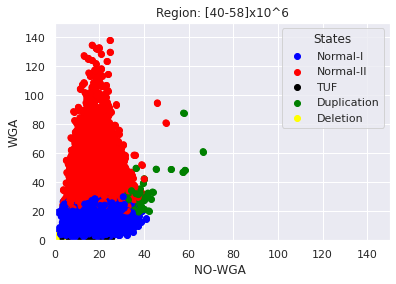

HMM labels color:  {'blue': [1, 124397], 'red': [2, 55195], 'black': [5, 225], 'green': [0, 78], 'yellow': [3, 100]}
State:  Duplication
WGA mean/var:  28.744871794871795 112.5259352399737
NO-WGA mean/var:  36.362435897435894 49.27383124589086
State:  Normal-I
WGA mean/var:  16.767838452695802 23.243152637777
NO-WGA mean/var:  18.724731544972947 22.0556619288242
State:  Normal-II
WGA mean/var:  32.24846743364436 86.33957017230206
NO-WGA mean/var:  19.126720536280462 19.945961204534324
State:  Deletion
WGA mean/var:  0.7158000000000001 1.2435703599999994
NO-WGA mean/var:  0.8987 1.6240753099999998
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.0205333333333337 1.8061286044444445
NO-WGA mean/var:  12.28128888888889 24.1231010054321
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [9]:
# load the region we want to use for prediction
region_name = "region_0_REGION_3_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [40-58]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r4"></a>  Region 4

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_4_CHR_6_MEAN_CUTOFF.txt
Sequence length:  170000
Observation length:  170000
Done. Execution time 0.4140569039991533 secs
Log-probability of ML Viterbi path:  -1138785.5853100521
Viterbi path length:  170001
There should be 0 gaps
Length of path  170000
Length of TUF+DELETION+TUF state:  45
Length of WGA Observations:  170000
Encountered gaps:  0
{'Duplication': 96, 'Normal-I': 137519, 'Normal-II': 31793, 'Deletion': 198, 'Single-Deletion': 0, 'TUF': 394, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


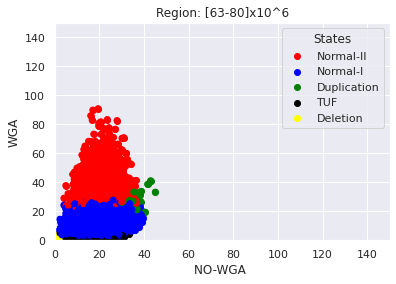

HMM labels color:  {'red': [2, 31793], 'blue': [1, 137519], 'green': [0, 96], 'black': [5, 394], 'yellow': [3, 198]}
State:  Duplication
WGA mean/var:  25.449583333333333 17.845372743055552
NO-WGA mean/var:  33.865312499999995 11.017714485677084
State:  Normal-I
WGA mean/var:  16.08870752405122 23.143158262315207
NO-WGA mean/var:  19.78720053229008 21.037614392636083
State:  Normal-II
WGA mean/var:  29.545129745541473 39.308274270745116
NO-WGA mean/var:  20.698288302456515 17.8357832242764
State:  Deletion
WGA mean/var:  0.454949494949495 0.9866876237118661
NO-WGA mean/var:  0.5532828282828284 1.2320553846546272
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.152664974619289 1.8159291923265224
NO-WGA mean/var:  15.763248730964465 39.04606254219382
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [10]:
# load the region we want to use for prediction
region_name = "region_0_REGION_4_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [63-80]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r5"></a>  Region 5

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_5_CHR_6_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.7883935869995184 secs
Log-probability of ML Viterbi path:  -1350463.8009392347
Viterbi path length:  200001
There should be 501 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  86
Length of WGA Observations:  199499
Encountered gaps:  501
{'Duplication': 118, 'Normal-I': 153056, 'Normal-II': 45963, 'Deletion': 81, 'Single-Deletion': 0, 'TUF': 281, 'GAP_STATE': 501, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


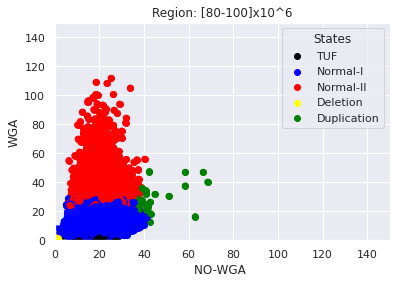

HMM labels color:  {'black': [5, 281], 'blue': [1, 153056], 'red': [2, 45963], 'yellow': [3, 81], 'green': [0, 118]}
State:  Duplication
WGA mean/var:  26.018813559322034 27.320334185578858
NO-WGA mean/var:  35.68101694915255 50.458393881068666
State:  Normal-I
WGA mean/var:  16.508719226949612 23.080188681463376
NO-WGA mean/var:  19.545804607463936 20.703823484950547
State:  Normal-II
WGA mean/var:  29.942019885560125 45.88590432899995
NO-WGA mean/var:  20.46102212649305 18.021141034756162
State:  Deletion
WGA mean/var:  0.936172839506173 1.5505693034598385
NO-WGA mean/var:  1.1883950617283952 1.8993196463953665
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.2370462633451957 1.4397652967920873
NO-WGA mean/var:  14.05085409252669 33.123163683337346
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [18]:
# load the region we want to use for prediction
region_name = "region_0_REGION_5_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr6',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr6', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [80-100]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r6"></a>  Region 6 

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_6_CHR_6_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.7716730539996206 secs
Log-probability of ML Viterbi path:  -1343564.5015216286
Viterbi path length:  200001
There should be 1 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  58
Length of WGA Observations:  199999
Encountered gaps:  1
{'Duplication': 86, 'Normal-I': 156022, 'Normal-II': 43419, 'Deletion': 44, 'Single-Deletion': 0, 'TUF': 428, 'GAP_STATE': 1, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


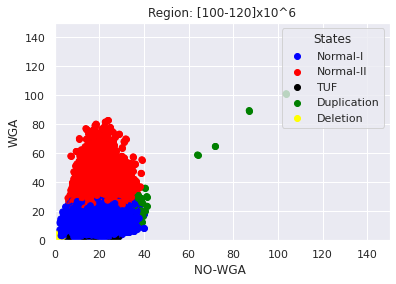

HMM labels color:  {'blue': [1, 156022], 'red': [2, 43419], 'black': [5, 428], 'green': [0, 86], 'yellow': [3, 44]}
State:  Duplication
WGA mean/var:  27.66790697674419 153.9536235262304
NO-WGA mean/var:  36.11116279069767 123.19072190373174
State:  Normal-I
WGA mean/var:  16.262298778377406 23.760846390381786
NO-WGA mean/var:  19.255782389662997 21.46104937921379
State:  Normal-II
WGA mean/var:  30.266877634215437 46.2617823026986
NO-WGA mean/var:  20.189873787973006 18.334963120024828
State:  Deletion
WGA mean/var:  1.7077272727272723 1.5281221074380165
NO-WGA mean/var:  2.0072727272727273 1.1834061983471076
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.210841121495327 1.8073698532622935
NO-WGA mean/var:  12.82429906542056 27.65950955541969
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [19]:
# load the region we want to use for prediction
region_name = "region_0_REGION_6_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr6',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr6', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [100-120]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r7"></a>  Region 7

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_7_CHR_6_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.8601773749996937 secs
Log-probability of ML Viterbi path:  -1339883.8685037573
Viterbi path length:  200001
There should be 0 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  124
Length of WGA Observations:  200000
Encountered gaps:  0
{'Duplication': 81, 'Normal-I': 157431, 'Normal-II': 42026, 'Deletion': 81, 'Single-Deletion': 0, 'TUF': 381, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


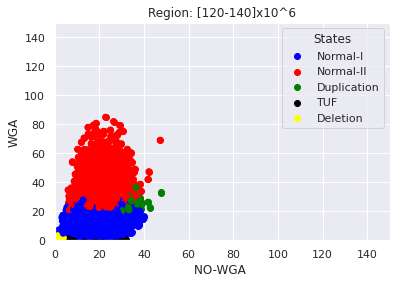

HMM labels color:  {'blue': [1, 157431], 'red': [2, 42026], 'green': [0, 81], 'black': [5, 381], 'yellow': [3, 81]}
State:  Duplication
WGA mean/var:  25.240246913580247 12.58567648224356
NO-WGA mean/var:  33.89358024691358 12.902477305288826
State:  Normal-I
WGA mean/var:  16.273872236090735 23.33123046760902
NO-WGA mean/var:  19.372065349264123 20.602863762230356
State:  Normal-II
WGA mean/var:  30.060320753819067 43.65859095027455
NO-WGA mean/var:  20.28461975919669 18.17476128524608
State:  Deletion
WGA mean/var:  1.678765432098765 1.6136206980643195
NO-WGA mean/var:  2.0888888888888886 1.7239802469135803
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.808556430446194 1.9728343990465755
NO-WGA mean/var:  14.708320209973753 32.818909514263474
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [20]:
# load the region we want to use for prediction
region_name = "region_0_REGION_7_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr6',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr6', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [120-140]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r8"></a>  Region 8

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_8_CHR_6_MEAN_CUTOFF.txt
Sequence length:  199989
Observation length:  199989
Done. Execution time 0.9419589190001716 secs
Log-probability of ML Viterbi path:  -1341487.352680109
Viterbi path length:  199990
There should be 0 gaps
Length of path  199989
Length of TUF+DELETION+TUF state:  333
Length of WGA Observations:  199989
Encountered gaps:  0
{'Duplication': 110, 'Normal-I': 153753, 'Normal-II': 44752, 'Deletion': 70, 'Single-Deletion': 0, 'TUF': 1304, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


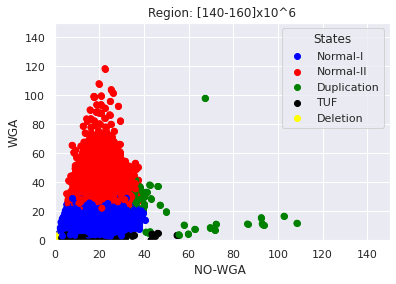

HMM labels color:  {'blue': [1, 153753], 'red': [2, 44752], 'green': [0, 110], 'black': [5, 1304], 'yellow': [3, 70]}
State:  Duplication
WGA mean/var:  24.442909090909087 106.55490790082648
NO-WGA mean/var:  40.39490909090909 259.7925759008264
State:  Normal-I
WGA mean/var:  16.117211761721723 25.00606399668462
NO-WGA mean/var:  18.764452140771233 21.31838451331732
State:  Normal-II
WGA mean/var:  30.512201912763675 50.62601809580614
NO-WGA mean/var:  19.821401948516268 18.74392651594901
State:  Deletion
WGA mean/var:  1.5148571428571427 1.9229964081632656
NO-WGA mean/var:  2.2075714285714287 2.0648555306122445
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.020613496932515 2.1462522309834773
NO-WGA mean/var:  15.780713190184052 32.26394665393645
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [21]:
# load the region we want to use for prediction
region_name = "region_0_REGION_8_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr='chr6',
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/viterbi_paths_chr6/"
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome='chr6', filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [140-160]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r9"></a>  Region 9

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_9_CHR_6_MEAN_CUTOFF.txt
Sequence length:  10000
Observation length:  10000
Done. Execution time 0.030002180003066314 secs
Log-probability of ML Viterbi path:  -66493.64150395145
Viterbi path length:  10001
There should be 600 gaps
Length of path  10000
Length of TUF+DELETION+TUF state:  42
Length of WGA Observations:  9400
Encountered gaps:  600
{'Duplication': 166, 'Normal-I': 6662, 'Normal-II': 2272, 'Deletion': 81, 'Single-Deletion': 0, 'TUF': 219, 'GAP_STATE': 600, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


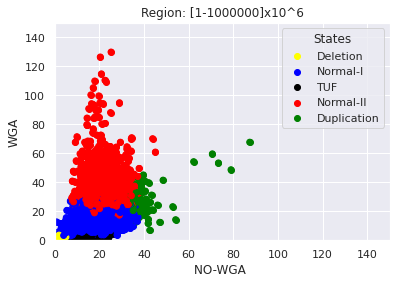

HMM labels color:  {'yellow': [3, 81], 'blue': [1, 6662], 'black': [5, 219], 'red': [2, 2272], 'green': [0, 166]}
State:  Duplication
WGA mean/var:  25.22349397590361 78.47155285237336
NO-WGA mean/var:  36.99066265060242 64.70816160908694
State:  Normal-I
WGA mean/var:  15.114190933653557 29.858326086630502
NO-WGA mean/var:  17.93426748724107 30.636598825478494
State:  Normal-II
WGA mean/var:  33.234040492957746 134.4453951180786
NO-WGA mean/var:  20.62381602112676 28.272032312982756
State:  Deletion
WGA mean/var:  1.7224691358024693 2.078023532998019
NO-WGA mean/var:  1.743086419753086 1.9125201036427375
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.2357990867579907 2.015001530410125
NO-WGA mean/var:  12.694520547945205 25.009191893413398
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [12]:
# load the region we want to use for prediction
region_name = "region_0_REGION_9_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [1-1000000]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r10"></a>  Region 10

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_10_CHR_6_MEAN_CUTOFF.txt
Sequence length:  99999
Observation length:  99999
Done. Execution time 0.30270100900088437 secs
Log-probability of ML Viterbi path:  -662329.3244597617
Viterbi path length:  100000
There should be 501 gaps
Length of path  99999
Length of TUF+DELETION+TUF state:  1043
Length of WGA Observations:  99498
Encountered gaps:  501
{'Duplication': 359, 'Normal-I': 75886, 'Normal-II': 19796, 'Deletion': 232, 'Single-Deletion': 0, 'TUF': 3224, 'GAP_STATE': 501, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 1}


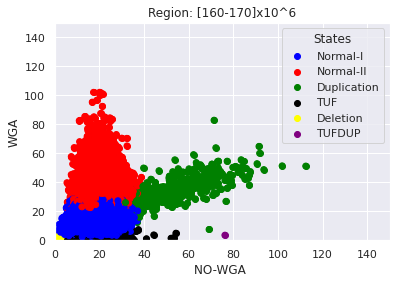

HMM labels color:  {'blue': [1, 75886], 'red': [2, 19796], 'green': [0, 359], 'black': [5, 3224], 'yellow': [3, 232], 'purple': [6, 1]}
State:  Duplication
WGA mean/var:  36.161643454038995 94.26794966674684
NO-WGA mean/var:  56.02534818941504 220.15737585369453
State:  Normal-I
WGA mean/var:  15.486586590411935 27.01142674702204
NO-WGA mean/var:  18.19896384049759 21.639925849653142
State:  Normal-II
WGA mean/var:  31.01877601535664 62.88132193588868
NO-WGA mean/var:  19.51277631844817 19.571246111009195
State:  Deletion
WGA mean/var:  0.8421982758620691 1.1490740468935792
NO-WGA mean/var:  1.7097844827586208 2.185444350104043
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.436293424317618 2.467843054100681
NO-WGA mean/var:  15.401789702233248 28.22449645577485
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP
WGA mean/var:  3.54 0.0
NO-WGA mean/var:  76.26 0.0


In [11]:
# load the region we want to use for prediction
region_name = "region_0_REGION_10_CHR_6_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [160-170]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))